In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.optim import lr_scheduler
import cv2
import shutil
import time
import copy
import torch.nn.init as init
import warnings
from PIL import Image


warnings.filterwarnings('ignore')

In [2]:
dataset_path="/kaggle/input/pins-face-recognition"
def create_dataset(path):
    train_df=pd.DataFrame(columns=["image_path","image_label"])   
    i=0
    for root, dirs, files in os.walk(path):
        if(i>0):
            label=os.path.basename(root).split("_")[1]
            for file in files:
                new_row = {'image_path': str(os.path.join(root, file)), 'image_label': str(label)}
                train_df = train_df.append(new_row, ignore_index=True)
        i+=1
        if(i>5):
            break
    return train_df



In [3]:
train_df=create_dataset("/kaggle/input/pins-face-recognition/105_classes_pins_dataset")
train_df = train_df.sample(frac=1).reset_index(drop=True)


In [4]:
train_df.head()

,image_path,image_label
0,/kaggle/input/pins-face-recognition/105_classe...,Maria Pedraza
1,/kaggle/input/pins-face-recognition/105_classe...,Logan Lerman
2,/kaggle/input/pins-face-recognition/105_classe...,Anthony Mackie
3,/kaggle/input/pins-face-recognition/105_classe...,Maria Pedraza
4,/kaggle/input/pins-face-recognition/105_classe...,Bobby Morley
5,/kaggle/input/pins-face-recognition/105_classe...,Logan Lerman
6,/kaggle/input/pins-face-recognition/105_classe...,Anthony Mackie
7,/kaggle/input/pins-face-recognition/105_classe...,Anthony Mackie
8,/kaggle/input/pins-face-recognition/105_classe...,Anthony Mackie
9,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther


In [5]:
actor_names = train_df["image_label"].unique().tolist()
classes={}
for i,actor in enumerate(actor_names):
    classes[actor]=i
classes

{'Maria Pedraza': 0,
 'Logan Lerman': 1,
 'Anthony Mackie': 2,
 'Bobby Morley': 3,
 'Alex Lawther': 4}

In [6]:
train_df["image_label"].unique()

array(['Maria Pedraza', 'Logan Lerman', 'Anthony Mackie', 'Bobby Morley',
       'Alex Lawther'], dtype=object)

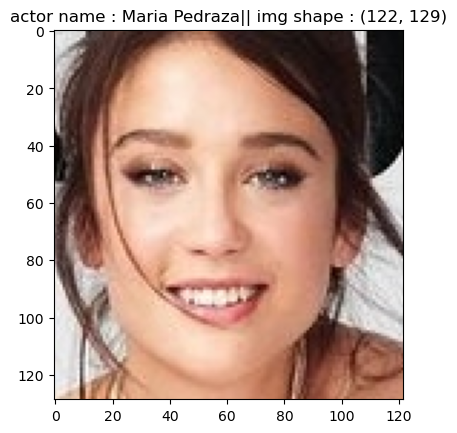

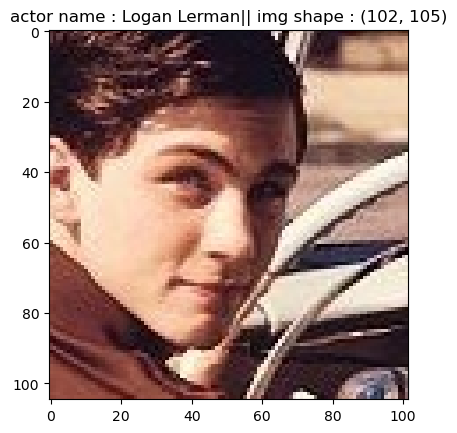

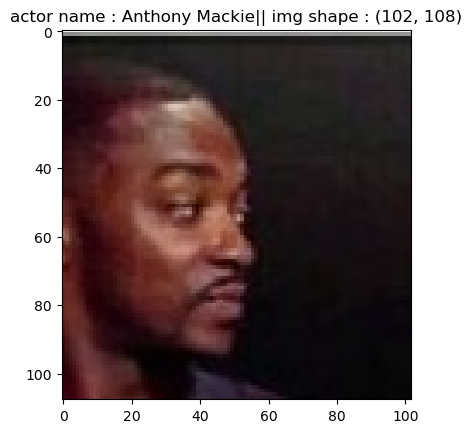

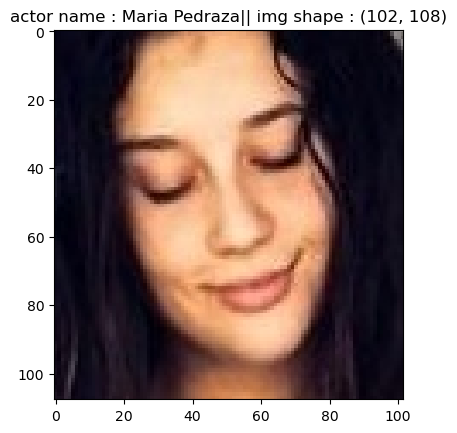

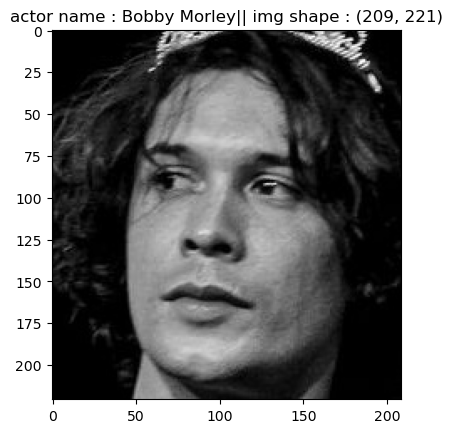

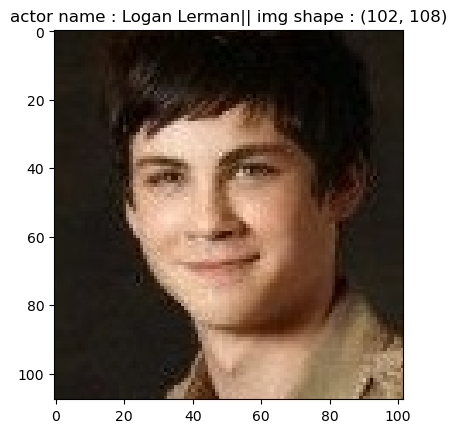

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


# Iterate over each row in the dataframe
for index, row in train_df.iterrows():
    # Load the image from path
    if(index>5):
        break
    path=row["image_path"]
    img = Image.open(path)
    target=row['image_label']
    # Plot the image using matplotlib
    plt.imshow(img)
    plt.title("actor name : "+str(target) + "|| img shape : " +str(img.size))
    plt.show()

In [33]:
SEED = 12345
torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-5
NUM_EPOCHS = 5
BATCH_SIZE = 16
HIDDEN_UNITS = 10
NUM_WORKERS = os.cpu_count()



 ## Loading data into dataset,dataloader,doing the necessary transforms

In [9]:

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, X, y=None, transform=None,train=True) -> None:
        
        self.images_path = X
        self.images_label = y
        self.transform = transform
        self.train=train
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images_path)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) :
        "Returns one sample of data, data and label (X, y)."
        img_path = self.images_path[index]
        if self.train:
            label = classes[self.images_label[index]]
        
        image = np.array(Image.open(img_path).convert('RGB'))
        
        
        if self.transform is not None:
            augmentations = self.transform(image=image)
            image         = augmentations['image']
            
        if self.train:
            return image, torch.as_tensor(label)
    
        return image
          
def create_dataloaders(
    X, 
    y, 
    transform: transforms.Compose,
    train,
    batch_size, 
    num_workers,
):
 
  # Use ImageFolder to create dataset(s)
  train_data_custom = ImageFolderCustom(X, y,transform=transform,train=train)
  # split data to train-test

  
  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data_custom,
      batch_size=batch_size,
      shuffle=train,
      num_workers=num_workers,
      pin_memory=True,
  )
  

  return train_dataloader

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Setup hyperparameters
image_train, image_val_test = train_test_split(train_df,test_size=.3,random_state=SEED)
image_train, image_val_test = image_train.reset_index(drop=True),image_val_test.reset_index(drop=True)


image_val, image_test = train_test_split(image_val_test,test_size=.5,random_state=SEED)
image_val, image_test = image_val.reset_index(drop=True),image_test.reset_index(drop=True)



X_train = image_train["image_path"]
X_val = image_val["image_path"]

y_train = image_train["image_label"]
y_val = image_val["image_label"]

X_test = image_test["image_path"]
y_test = image_test["image_label"]
# Create transforms

# Create DataLoaders with help from data_setup.py

normalize = A.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225], max_pixel_value=255
)
H  = 224
W  = 224
data_transform = A.Compose([
    A.Resize(H,W),
    normalize,
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(H,W),
    normalize,
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(H,W),
    normalize,
    ToTensorV2(),
])


train_dataloader = create_dataloaders(
    X=X_train, 
    y=y_train, 
    transform=data_transform,
    train=True,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
)
val_dataloader = create_dataloaders(
    X=X_val, 
    y=y_val, 
    transform=val_transform,
    train=True,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
)

test_dataloader = create_dataloaders(
    X=X_test, 
    y=y_test, 
    transform=test_transform,
    train=False,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
)

 

In [ ]:
# Create model with help from model_builder.py
from torchvision.models import efficientnet_b3,EfficientNet_B3_Weights
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.fc=nn.Sequential(
            nn.Linear(in_features=1000, out_features=12, bias=True),
        )
    def forward(self, image):
        return self.fc(self.model(image))


model_pretrained=Net()

import torch
import torch.nn as nn

class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes=10):
        super(FaceRecognitionModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model_frm=FaceRecognitionModel(num_classes=5)



In [12]:
def save_checkpoint(state, filename):
    print('--> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print('--> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

In [13]:


"""
Contains functions for training and testing a PyTorch model.
"""
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
   
    # Put model in train mode
    model.train()
    # Setup train loss and train accuracy values
    train_loss= 0
    # Loop through data loader data batches
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        # Send data to target device
        X, y = X.to(device).to(torch.float32), y.to(device)
        # 1. Forward pass
        pred_logits=model(X).to(torch.float)
        loss = loss_fn(pred_logits, y)
        train_loss += loss.item() 
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    return np.sqrt(train_loss)

def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 
    # Setup test loss and test accuracy values
    test_loss= 0
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            # Send data to target device
            X, y = X.to(device).to(torch.float32), y.to(device)
        # 1. Forward pass
            pred_logits = model(X).to(torch.float)
            # 2. Calculate and accumulate loss
            loss = loss_fn(pred_logits, y)
            test_loss += loss.item()
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    return np.sqrt(test_loss)
    
def train_loop(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          patience,
          checkpoint_name) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": [],
    }
    
    # Make sure model on target device
    model.to(device)
    last_loss=99999
    checkpoint = {
          'state_dict': model.state_dict(),
          'optimizer':  optimizer.state_dict()
            }
    
    best_loss=99999
    best_model_state=[]
    best_optimizer_state=[]
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        current_loss = val_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)
        # Early stopping
        if(current_loss<best_loss):
            best_loss=current_loss
            best_model_state=model.state_dict()
            best_optimizer_state=optimizer.state_dict()
            
        if current_loss > last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break

        else:
            print('trigger times: 0')
            trigger_times = 0
            
        #scheduler.step()
        last_loss = current_loss
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {current_loss:.4f} | "
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(current_loss)
        
    checkpoint = {
          'state_dict': best_model_state,
          'optimizer':  best_optimizer_state,
            }
    save_checkpoint(checkpoint, filename=checkpoint_name+'.pth.tar')
    # Return the filled results at the end of the epochs
    return results

In [ ]:
def choose_model():
    choice=int(input("choose 0 for classic approach || 1 to use transfer learning"))
    if(choice==0):
        return model_frm
    else :
        return model_pretrained

In [36]:
# Set loss and optimizer
model=choose_model()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

%%time
train_res=train_loop(model=model,   
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=50,
      device=device,
      patience=3,
      checkpoint_name="fifth_model")

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 1 | train_loss: 1.2917 | test_loss: 1.2828 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 2 | train_loss: 1.2452 | test_loss: 1.2248 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 3 | train_loss: 1.1864 | test_loss: 1.2109 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 4 | train_loss: 1.1640 | test_loss: 1.1585 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 5 | train_loss: 1.1247 | test_loss: 1.1283 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 6 | train_loss: 1.0504 | test_loss: 1.1215 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 7 | train_loss: 1.0079 | test_loss: 1.1603 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 2
Epoch: 8 | train_loss: 0.9334 | test_loss: 1.1644 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 9 | train_loss: 0.9436 | test_loss: 1.0220 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 10 | train_loss: 0.9175 | test_loss: 1.1171 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 11 | train_loss: 0.8555 | test_loss: 0.9808 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 12 | train_loss: 0.8026 | test_loss: 0.9799 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 13 | train_loss: 0.8146 | test_loss: 1.0724 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 14 | train_loss: 0.7611 | test_loss: 0.9827 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 15 | train_loss: 0.7292 | test_loss: 1.1696 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 16 | train_loss: 0.7789 | test_loss: 1.0872 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 17 | train_loss: 0.7748 | test_loss: 1.0346 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 18 | train_loss: 0.7080 | test_loss: 0.9946 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 19 | train_loss: 0.6714 | test_loss: 1.1037 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 20 | train_loss: 0.6694 | test_loss: 1.0647 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 21 | train_loss: 0.5828 | test_loss: 1.0379 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 22 | train_loss: 0.6063 | test_loss: 1.1151 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 2
Epoch: 23 | train_loss: 0.6127 | test_loss: 1.1178 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 24 | train_loss: 0.6304 | test_loss: 0.9970 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 25 | train_loss: 0.5865 | test_loss: 0.9819 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 26 | train_loss: 0.6010 | test_loss: 1.0472 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 27 | train_loss: 0.5580 | test_loss: 1.0115 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 28 | train_loss: 0.5072 | test_loss: 1.0142 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 2
Epoch: 29 | train_loss: 0.5155 | test_loss: 1.0816 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 30 | train_loss: 0.4953 | test_loss: 1.0078 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 31 | train_loss: 0.4139 | test_loss: 1.1148 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 0
Epoch: 32 | train_loss: 0.4566 | test_loss: 1.0508 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 1
Epoch: 33 | train_loss: 0.4603 | test_loss: 1.0841 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 2
Epoch: 34 | train_loss: 0.4929 | test_loss: 1.1236 | 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

trigger times: 3
Early stopping!
Start to test process.
--> Saving checkpoint
CPU times: user 5min 59s, sys: 15 s, total: 6min 14s
Wall time: 6min 28s


## Submission

In [37]:
# Predict on test set

model.eval()
m = nn.Softmax(dim=1)
preds = []
with torch.no_grad():
  for batch in test_dataloader:
    images = batch
    logits = model(images.to(device))
    pred= torch.argmax(logits,dim=1)
    preds.extend([x for x in pred.detach().cpu().numpy()])
# Prepare submission file
y_test_labels = [classes[i] for i in(y_test)]
sub = pd.DataFrame({'ImageId': X_test, 'Predicted': preds, "Truth" : y_test_labels})
sub.head()

# **Results**

In [57]:
results=pd.Series(sub["Predicted"]==sub["Truth"]).value_counts().tolist()
print("final accuracy :",results[0]/(results[0]+results[1]))

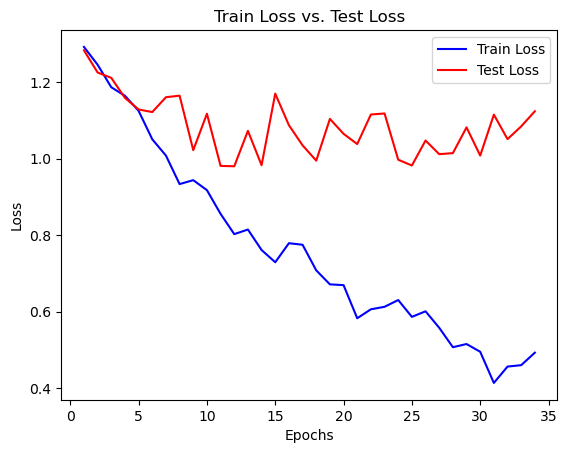

In [42]:
# Create a range of epochs
train_loss=train_res["train_loss"]
test_loss=train_res["test_loss"]
epochs = range(1, len(train_loss) + 1)

# Plot the train_loss and test_loss
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()

# Show the plot
plt.show()

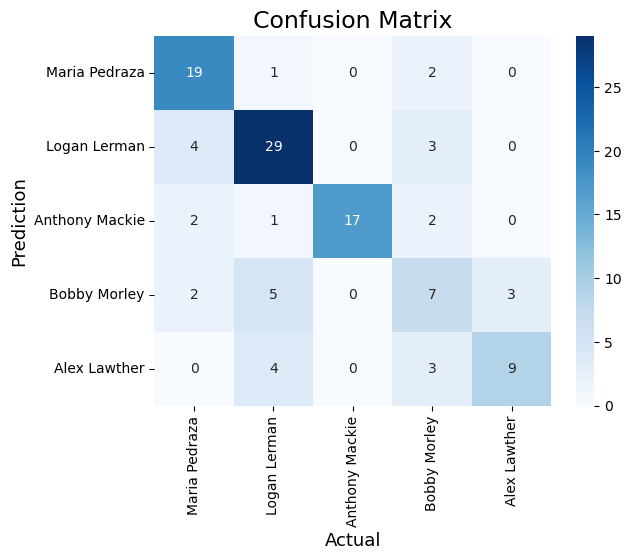

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
true_labels= sub["Truth"]
predicted_labels=sub["Predicted"]
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm,
            cmap="Blues",
            annot=True,
            fmt='g',
            xticklabels=classes.keys(),
            yticklabels=classes.keys())
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()